# Noisy QITE

We will refer to Pauli matrices by their indices: $[I, X, Y, Z] \equiv [0, 1, 2, 3]$
For consistency in notation, we use the following mapping for n-qubit operators, composed of a Pauli matrices acting on each qubit. This is the indexing used throughout the code.

In [1]:
import itertools

def get_pauli_dicts(nqbits):
    pauli_indices = [0,1,2,3]
    pauli_pairs = list(itertools.product(pauli_indices, repeat=nqbits))
    pauli_pair_dict = pauli_pair_dict = {pauli_pairs[i] : i for i in range(len(pauli_pairs))}
    return pauli_pairs, pauli_pair_dict

## Measure the Pauli Expectations

In **measure** we define circuits to measure the expectation value of any Pauli string. Read more: https://docs.microsoft.com/en-us/quantum/concepts/pauli-measurements

In [2]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, BasicAer, IBMQ
from qiskit.compiler import transpile
# for noise mitigation
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [3]:
# Circuit to measure the expectation value of any Pauli string
# For 2-qubit Pauli measurements, see https://docs.microsoft.com/en-us/quantum/concepts/pauli-measurements
def measure_pauli_expectations(qbackend, qc, qbits, idx, shots=8192, noise=False):
    '''
    Compute multi-qubit Pauli expectations by changing Pauli measurements to a 
    diagonal ({Z, I}^n) basis
    '''
    # variable to return
    pauli_expectation = 1
    # for circuit transpilation
    # qbackend basis gates
    basis_gates = qbackend.configuration().basis_gates
    # qbackend coupling map
    coupling_map = qbackend.configuration().coupling_map
    
    # initialize counts dict
    counts = {}
    
    # start measurement 
    nqbits = len(qbits)
    idx_pair = list(pauli_pairs[idx])
    
    # I x I ....
    cond1 = [0] * nqbits
    # Z x I ....
    cond2 = [3] + [0] * (nqbits - 1)
    
    # if I x I .... or Z x I .... just return the expectation is 1
    if idx_pair == cond1:
        return 1
    
    elif idx_pair == cond2:
        pass
    
    # Step 1. convert multi qubit operator (Pauli string) to Z x I ... basis
    # if zero qubit Pauli gate is I, swap 0 qubit with first qubit with non-identity Pauli gate 
    # for example, I X Y Z -> X I Y Z
    if idx_pair[0] == 0:
        # get first qubit acted on by Pauli matrix other than I
        for j in range(1,len(idx_pair)):
            if idx_pair[j] != 0:
                qc.swap(qbits[0],qbits[j])
                idx_pair[0], idx_pair[j] = idx_pair[j], idx_pair[0]
                break

    # cnot_list keeps track of the qubits q to apply cnot gate between zero qubit and q... qc.cx(q,0)
    cnot_list = [-1] + qbits[1:]

    # proceed to implement the change of basis by applying unitaries
    for i in range(nqbits):
        # I
        if idx_pair[i] == 0:
            cnot_list[i] = -1
        # X
        elif idx_pair[i] == 1:
            qc.h(qbits[i])
        # Y
        elif idx_pair[i] == 2:
            qc.rx(np.pi/2,qbits[i])
        # Z
        elif idx_pair[i] == 3:
            pass
        else:
            raise ValueError

    # entangle by apply CNOT gates between all qubits acted on by Pauli matrix other than I and 0 qubit
    for q in cnot_list:
        if q != -1:
            qc.cx(q, qbits[0])

    # add noise model
    if noise:
#         # entangle for simultaneous measurement of pauli string expectation and parity
#         for i in range(nqbits-1):
#             qc.cx(qbits[i],qbits[i+1])
        
        # Step 2: measure
        qc.measure(qc.qregs[0][0],qc.cregs[0])
        
        # Build noise model from backend properties
        noise_backend = provider.get_backend('ibmq_london')
        noise_model = NoiseModel.from_backend(noise_backend)

        # Get coupling map from noise backend
        noise_coupling_map = noise_backend.configuration().coupling_map

        # Get basis gates from noise model
        noise_basis_gates = noise_model.basis_gates
        
        # execute a noisy simulation
        job = execute(qc, qbackend,
            coupling_map=noise_coupling_map,
            basis_gates=noise_basis_gates,
            noise_model=noise_model,
            shots=shots,
            optimization_level=optimization_level)

        results = job.result()
        
        # Readout error mitigation: https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html
        # create set of circuits to take measurements for each of the 2^nqbits basis states
        meas_calibs, state_labels = complete_meas_cal(qr=QuantumRegister(1), circlabel='mcal')
        
        # get calibration fitter and calibration matrix
        job_cal = execute(meas_calibs, backend=qbackend,
                coupling_map=noise_coupling_map,
                basis_gates=noise_basis_gates,
                noise_model=noise_model,
                shots=shots,
                optimization_level=optimization_level)
        
        cal_results = job_cal.result()
        
        meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
        
        # get the filter object
        meas_filter = meas_fitter.filter
        
        # get the results with noise mitigation
        mitigated_results = meas_filter.apply(results)
        
        mitigated_counts = mitigated_results.get_counts(0)
        counts = mitigated_counts
        
#         if '00' not in counts:
#             counts['00'] = 0
#         if '11' not in counts:
#             counts['11'] = 0
#         if '01' not in counts:
#             counts['01'] = 0
#         if '10' not in counts:
#             counts['10'] = 0
#         pauli_expectation = (counts['00'] - counts['11']) / (counts['00'] + counts['11'])

        if '0' not in counts:
            counts['0'] = 0
        if '1' not in counts:
            counts['1'] = 0
        pauli_expectation = (counts['0'] - counts['1']) / shots
        
    # just transpile circuit
    else:
        # Step 2: measure the 0 qubit
        qc.measure(qc.qregs[0][0],qc.cregs[0])
        
        # transpile circuit to adapt to qbackend
        qc_transpiled = transpile(qc, backend=qbackend, basis_gates=basis_gates, coupling_map=coupling_map)
        job = execute(qc_transpiled, qbackend, shots=shots, optimization_level=optimization_level)
        counts = job.result().get_counts()

        if '0' not in counts:
            counts['0'] = 0
        if '1' not in counts:
            counts['1'] = 0
        pauli_expectation = (counts['0'] - counts['1']) / shots
    
    return pauli_expectation


## Propagate the State

In **propagate**, we loop through the different values store in alist to construct the states. alist is stored as a list of lists and the indices are $a[timestep][gate]$. For a timestep $\Delta \tau$, the gate indices of $a$ correspond to:

$$
a[0]=e^{-ia[II]\Delta\tau\hat{I} \otimes \hat{I}} \text{,  } \; 
a[1]=e^{-ia[IX]\Delta\tau\hat{I} \otimes \hat{X}} \text{,  } \;
a[2]=e^{-ia[IY]\Delta\tau\hat{I} \otimes \hat{Y}} \text{,  } \;
a[3]=e^{-ia[ZZ]\Delta\tau\hat{I} \otimes \hat{Z}}
$$
$$
a[4]=e^{-ia[XI]\Delta\tau\hat{X} \otimes \hat{I}} \text{,  } \; 
a[5]=e^{-ia[XX]\Delta\tau\hat{X} \otimes \hat{X}} \text{,  } \;
a[6]=e^{-ia[XY]\Delta\tau\hat{X} \otimes \hat{Y}} \text{,  } \;
a[7]=e^{-ia[XZ]\Delta\tau\hat{X} \otimes \hat{Z}}
$$
$$
a[8]=e^{-ia[YI]\Delta\tau\hat{Y} \otimes \hat{I}} \text{,  } \; 
a[9]=e^{-ia[YX]\Delta\tau\hat{Y} \otimes \hat{X}} \text{,  } \;
a[10]=e^{-ia[YY]\Delta\tau\hat{Y} \otimes \hat{Y}} \text{,  } \;
a[11]=e^{-ia[YZ]\Delta\tau\hat{Y} \otimes \hat{Z}}
$$
$$
a[12]=e^{-ia[ZI]\Delta\tau\hat{Z} \otimes \hat{I}} \text{,  } \; 
a[13]=e^{-ia[ZX]\Delta\tau\hat{Z} \otimes \hat{X}} \text{,  } \;
a[14]=e^{-ia[ZY]\Delta\tau\hat{Z} \otimes \hat{Y}} \text{,  } \;
a[15]=e^{-ia[ZZ]\Delta\tau\hat{Z} \otimes \hat{Z}}
$$

The 0 index stores the coefficient for the identity matrix $\hat{I}$ on both qubits, which is a global phase for each qubit that we can ignore.

We can break down the matrix exponential of the Kronecker product of two Pauli matrices as:

$$e^{-i \theta \Delta\tau \bigotimes_{j} \sigma_{j}} = \cosh(-i \theta \Delta\tau) \bigotimes_{j} I + \sinh(-i \theta \Delta\tau) \bigotimes_{j} \sigma_{j} = \cos(\theta \Delta\tau) \bigotimes_{j} I - i \sin(\theta \Delta\tau) \bigotimes_{j} \sigma_{j}$$

For example,

$$e^{-ia[XY]\Delta\tau\hat{X} \otimes \hat{Y}} = \cos(a[XY] \Delta\tau) (I \otimes I) - i \sin(a[XY] \Delta\tau) (X \otimes Y)$$

To implement this in terms of gates on a quantum computer, refer to page 210 in Nielsen and Chuang: http://mmrc.amss.cas.cn/tlb/201702/W020170224608149940643.pdf

We need to apply a phase shift to the system. Phase is $e^{-i \Delta \tau}$ if the parity of the $n$ qubits in the computational basis is even, and $e^{i \Delta \tau}$ if odd. For 2 qubits, this is the matrix exponential of $i \Delta \tau Z \otimes Z$

$$ e^{-i \Delta \tau Z \otimes Z} =
\begin{pmatrix}
e^{-i \Delta \tau} & 0 & 0 & 0\\
0 & e^{i \Delta \tau} & 0 & 0\\
0 & 0 & e^{i \Delta \tau} & 0\\
0 & 0 & 0 & e^{-i \Delta \tau}\\
\end{pmatrix}
$$

The function **applyPhase** implements this $e^{-i \Delta \tau Z \otimes Z}$ operation

In [4]:
def applyPhase(qc,qbits,angle, id_idx_list):
    a = list(range(0,len(qbits)-1))
    b = id_idx_list
    
    # c is qubits [0, ..., nqbits-2] excluding qubits acted on by I (where we do nothing)
    c = list(set(a).difference(set(b)))
    
    # apply the cnot gates between all qubits in c and last qubit, qubit (nqbits-1)
    for i in c:
        qc.cx(qbits[i],qbits[-1])
        
    # z rotation on last qubit
    qc.rz(angle,qbits[-1])
    
    # apply the cnot gates between all qubits in c and last qubit, qubit (nqbits-1)
    c.reverse()
    for i in c:
        qc.cx(qbits[i],qbits[-1])

In [5]:
def propagate_single_term(qc,qbits,idx_pair,angle):
    # single qubit rotation case... all qubits acted on by I except for one
    nonzero_count = 0
    single_rot_q = -1
    for j in range(len(idx_pair)):
        if idx_pair[j] != 0:
            nonzero_count += 1
            single_rot_q = j
        if nonzero_count > 1:
            single_rot_q = -1
            break   

    if single_rot_q != -1:
        if idx_pair[single_rot_q] == 1:
            qc.rx(angle,qbits[single_rot_q])
        elif idx_pair[single_rot_q] == 2:
            qc.ry(angle,qbits[single_rot_q])
        elif idx_pair[single_rot_q] == 3:
            qc.rz(angle,qbits[single_rot_q])

    # multi-qubit rotation
    else:
        id_idx_list = []
        for j in range(len(idx_pair)):
            if idx_pair[j] == 0:
                id_idx_list.append(j)
            elif idx_pair[j] == 1:
                qc.h(qbits[j])
            elif idx_pair[j] == 2:
                qc.rx(np.pi/2, qbits[j])
            elif idx_pair[j] == 3:
                pass
            else:
                raise ValueError

        # maybe skip the CNOT on qubits acted on by I?
        applyPhase(qc,qbits,angle, id_idx_list)

        # apply conjugate transpose
        for j in range(len(idx_pair)):
            if idx_pair[j] == 0:
                pass
            elif idx_pair[j] == 1:
                qc.h(qbits[j])
            elif idx_pair[j] == 2:
                qc.rx(-np.pi/2, qbits[j])
            elif idx_pair[j] == 3:
                pass
            else:
                raise ValueError


def propagate(qc,qbits,alist):
    nqbits = len(qbits)
    # Circuit to propagate the state
    if len(alist) == 0:
        None
    else:
        for t in range(len(alist)):
            for i in range(1,4**nqbits):
                angle = np.real(alist[t][i])
                idx_pair = pauli_pairs[i]
                propagate_single_term(qc,qbits,idx_pair,angle)

## Update Rotation Angles For Unitary Imaginary Time Evolution

We denote **alist** as $a[m]$, the matrix of rotations per imaginary time step for our unitary operator that recreates imaginary time evolution. Recall:

$$ A[m] = \sum_{i_{1} \ldots i_{k}} a[m]_{i_{1} \ldots i_{k}} \sigma_{i_{1}} \ldots \sigma_{i_{k}} \equiv \sum_{I} a[m]_{I} \sigma_{I}$$

The idea behind QITE is to define a unitary operator $e^{-i \Delta \tau A[m]}$ and apply it to a state $| \Psi \rangle$ to reproduce the state:

$$| \Psi' \rangle = c^{-1/2} e^{- \Delta \tau h[m]} | \Psi \rangle$$

We define the distance between the desired and initial states as $| \Delta_{0} \rangle = \left( {| \Psi' \rangle - | \Psi \rangle} \right) /{\Delta \tau}$ and the difference between the evolved and initial states as $| \Delta \rangle = -iA[m] | \Psi \rangle$. The goal is to minimize $\| \Delta_{0} - \Delta \|$. This corresponds to minimizing the quadratic function (from SI of the Motta paper):

$$f \left( a[m] \right) = f_{0} + \sum_{I} b_{I} a[m]_{I} + \sum_{I,J} a[m]_{I} S_{IJ} a[m]_{J}$$
$$f_{0} = \langle \Delta_{0} | \Delta_{0} \rangle \text{,  } S_{IJ} = \langle \Psi | \sigma_{I}^{\dagger} \sigma_{J} | \Psi \rangle \text{,  } b_{I} = i \langle \Psi | \sigma_{I}^{\dagger} | \Delta_{0} \rangle - i \langle \Delta_{0} | \sigma_{I} | \Psi \rangle = -\frac{i}{\sqrt{c}} \langle \Psi | \sigma_{I}^{\dagger} h[m] | \Psi \rangle$$

The minimum is the solution to the linear equation $\left( S + S^{T} \right) a[m] = -b$, which we solve by applying the generalized inverse or via some iterative algorithm.

To compute $S$, we need to the matrix elements:

$$S_{ij} = \langle \psi | Q_{i} Q_{j} | \psi \rangle = \langle \psi | ( \sigma_{i0} \otimes \sigma_{i1} ) ( \sigma_{j0} \otimes \sigma_{j1} ) | \psi \rangle = \langle \psi | \left( \sigma_{i0} \sigma_{j0} \otimes \sigma_{i1} \sigma_{j1} \right) | \psi \rangle$$

To compute $b$, we need the vector elements:
$$b_{i} = i \langle \psi | Q_{i} | \Delta_{0} \rangle - h.c. = i \langle \psi | {( \sigma_{i0} \otimes \sigma_{i1})} | \Delta_{0} \rangle - h.c.$$


These computations are done in the **update_alist** function. But to compute these elements, we first need to compute the 2-qubit Pauli expectations in a state propagated by our unitary imaginary time evolution.

For the 1-qubit case, we need to construct the matrix $S_{ij} = \langle \psi | \sigma_{i} \sigma_{j} | \psi \rangle$ and the vector $b_{i}$. Well, our earlier functions allow us to measure the expectation values of the different pauli matrices. How do we obtain $S_{ij}$ from a list of $\langle \psi | \sigma | \psi \rangle$? We can exploit the fact that up to some coefficients, $\sigma_{i}\sigma_{j} = c_{ij}\sigma_{ij}$. For example, $\sigma_{x}\sigma_{y} = i\sigma_{z}$. We will need a matrix to keep track of what pauli matrix and coefficient we get for $\sigma_{i}\sigma_{j}$. A pragmatic approach is to hard-code these 1-qubit matrix multiplication matrices.

For the 2-qubit case, we can reuse the 1-qubit matrices. For example,
$(X \otimes X) (X \otimes Y) = XX \otimes XY = I \otimes i Z$

Another way is to hard-code the 2-qubit matrices by directly populating the Lie algebra rules, as we do below.

In [6]:
import sys
sys.path.append('classical')

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm 
from binary_functions import Int2Bas,Bas2Int,Opp2Str,Str2Opp
from Pmn import PPmunu

In [8]:
def lie_algebra(mu,nu,n):
    # Return coefficients and index for sigma mu,sigma nu
    index = ''
    coeff = 1
    for i in range(n):
        tmpA,tmpB = PPmunu(mu[i]+nu[i])
        index += tmpA
        coeff *= tmpB
    return coeff,Bas2Int(Str2Opp(index),4)

In [9]:
def get_index_coeff(n):
    index = np.zeros([4**n,4**n],dtype=int)
    coeff = np.zeros([4**n,4**n],dtype=complex)
    for i in range(4**n):
        for j in range(4**n):
            coeff[i,j],index[i,j] = lie_algebra(Opp2Str(Int2Bas(i,4,n)),Opp2Str(Int2Bas(j,4,n)),n)
    return index,coeff

We now want to obtain the coefficients $a[m]$ at the current time step and append to alist. In the **update_alist** function, we use the **index** and **coeff** matrices and the function np.linalg.std to construct the S matrix and b vector and solve for x, the rotation angle used in state propagation. Because the rotation gate is defined as $e^{-i\theta/2\sigma}$, we multiply the x by 2 before storing them in alist. More specifically:

In [10]:
def update_alist(sigma_expectation,alist,db,delta,hm):
    '''
    Obtain A[m]
    To do this, we compute the S matrix and the b vector. We also need to compute the norm c
    Details:
    Each local Hamiltonian term hm can be a sum of many 2-qubit operators...
     ... see the construction of the hm_list to see why... for each term in hm (hm[i]):
    hm[i][1][0] is the multiplicative constant in the Hamiltonian
    hm[i][0][0] is the index of the Pauli matrix for qubit 0
    hm[i][0][1] is the index of the Pauli matrix for qubit 1
    '''
    # c is the squared norm
    c = 1
    for i in range(len(hm)):
        hm_idx = pauli_pair_dict[tuple(hm[i][0])]
        c -= 2 * db * hm[i][1][0] * sigma_expectation[hm_idx]
    # c is now the norm, after we take its square root
    c = np.sqrt(c)
    
    dim = len(sigma_expectation)
    
    # Initialize S matrix
    S = np.zeros([dim, dim], dtype=complex)
    # Initialize b vector
    b = np.zeros([dim], dtype=complex)
    
    for i in range(dim):
        # Step 1: Obtain S matrix
        for j in range(dim):
            S[i, j] = sigma_expectation[index[i,j]] * coeff[i,j]
#             print(i, j, S[i, j])

        # Step 2: Obtain b vector
        b[i] += (sigma_expectation[i]/c-sigma_expectation[i])/(db)
        # iterate through hm terms
        for j in range(len(hm)):
            hm_idx = pauli_pair_dict[tuple(hm[j][0])]            
            b[i] -= hm[j][1][0]*coeff[i,hm_idx]*sigma_expectation[index[i,hm_idx]]/c
        b[i] = 1j*b[i] - 1j*np.conj(b[i])
#         print(i, b[i])
        
    # Step 3: Add regularizer... dim x dim matrix with delta on main diagonal and 0s elsewhere
    dalpha = np.eye(dim)*delta

    # Step 4: Solve for linear equation, the solution is multiplied by -2 because of the definition of unitary rotation gates is exp(-i theta/2)
    x = np.linalg.lstsq(S + np.transpose(S) + dalpha, -b, rcond=-1)[0]
    alist.append([])
                
    for i in range(len(x)):
        angle = x[i] * db
#         # compensate for over/under rotation caused by noise
# #         min_gate_fidelity = 0.9990
#         avg_gate_fidelity = 0.9995

#         # at high fidelity close to 1, we use that var /approx mean
#         over_rot_var = np.sqrt(2 * (1 - avg_gate_fidelity)) # approximation of arccos(F) for F /approx 1
#         # normal dist. centered at zero
#         over_rot = np.random.normal(0,over_rot_var,1)

#         angle += over_rot
        
        alist[-1].append(-2 * angle)
    return c



## Full QITE Protocol

Now we implement the full QITE protocol. It will be good to have a big picture of what should be done. We step through imaginary time and at each time step, we should first measure the expectation values of the pauli matrices $\sigma$. This is indicated in the first two lines of the for loop. Using the relevant expectation values, we obtain the coefficients $a[m]$ in equation (2.5) of Lecture 12 using the update rule in equation (2.9-2.11). We store it in a list and use this to propagate our state. Note we have to always reconstruct our state for each new measurements we make. Finally, we measure the current energy values. Let us construct the required functions starting with **get_expectation**. We make use of the **measure** function we constructed earlier. The key here is to propagate our state using the coefficients in alist. We do this using the **propagate** function.

In [11]:
def ansatz(p, qbits):
    None

def build_basic_circuit(nqbits, ncbits, nancbits=0):
    # quantum nqbits register
    qr = QuantumRegister(nqbits)
    # classical 1 bit readout register
    ro = ClassicalRegister(ncbits, name='ro')
    if nancbits > 0:
        # ancilla
        qr_anc = QuantumRegister(nancbits)
        qc = QuantumCircuit(qr, qr_anc, ro)
    else:
        qc = QuantumCircuit(qr, ro)
    return qc

# use this to avoid the extra time complexity of propagating and measuring again... the values we want are already in sigma_expectation
def get_energy_from_sigma(sigma_expectation, hm_list, verbose=True):
    Energy = 0
    Nterms = len(hm_list)
    for i in range(len(hm_list)):
        hm = hm_list[i]
        # For each Pauli matrix pair (2-qubit operator) in the Hamiltonian, 
        for j in range(len(hm)):
            # pauli pair to retrieve the measurement for in sigma_expectations
            pauli_pair = tuple(hm[j][0])
            # energy contribution of this term
            tmp = hm[j][1][0] * sigma_expectation[pauli_pair_dict[pauli_pair]]
            if verbose:
                print("pauli_pair {} energy contribution: {}".format(pauli_pair, tmp))
            Energy += tmp
    return Energy

def measure_energy(qbackend, qbits, alist, shots, hm_list, display=False, noise=False, optimization_level=1):
    # Measure the energy at the end of each time step
    Energy = 0
    Nterms = len(hm_list)
    nqbits = len(qbits)
    ncbits = 1

    for i in range(len(hm_list)):
        hm = hm_list[i]
        for j in range(len(hm)):
                        
            pauli_pair = tuple(hm[j][0])
            idx = pauli_pair_dict[pauli_pair]
            
            qc = build_basic_circuit(nqbits, ncbits, nancbits=0)

            # propagate the state
            propagate(qc,qbits,alist)
            # measure Pauli string
            pauli_expectation = measure_pauli_expectations(qbackend,qc,qbits,idx,shots=shots,noise=noise)
                
            tmp = hm[j][1][0]*pauli_expectation
            print("pauli_pair {} energy contribution: {}".format(pauli_pair, tmp))
            Energy += tmp
            
            if display:
                print(qc)
                
    return Energy

def get_expectation(qbackend, qbits, alist, shots, display=False, noise=False, optimization_level=1):
    # Obtain the expectation values of the Pauli string at each time step
    nqbits = len(qbits)
    ncbits = 1
    dim = 4**nqbits
    sigma_expectation = np.zeros([dim], dtype=complex)

    for idx in range(dim): 
        
        qc = build_basic_circuit(nqbits, ncbits, nancbits=0)

        # propagate the state
        propagate(qc,qbits,alist)
        # measure Pauli string
        pauli_expectation = measure_pauli_expectations(qbackend,qc,qbits,idx,shots=shots,noise=noise)
        
        sigma_expectation[idx] = pauli_expectation
        
        if display:
            print(qc)

    return sigma_expectation

def qite_step(qbackend, qbits, alist, shots, db, delta, hm_list, verbose=True, display=False, noise=False, optimization_level=1):
    sigma_expectation = get_expectation(qbackend, qbits, alist, shots, display=display, noise=noise, optimization_level=optimization_level)
    energy = get_energy_from_sigma(sigma_expectation, hm_list, verbose=verbose)
    for j in range(len(hm_list)):
        update_alist(sigma_expectation, alist, db, delta, hm_list[j]) # = norm
    return alist, sigma_expectation, energy

def qite(qbackend, qbits, shots, db, delta, N, hm_list, verbose=True, display=False, noise=False, optimization_level=1):
    E = np.zeros([N+1],dtype=complex)
    alist = []

    # Qite main loop
#     QITE_expectations = []
    for i in range(0,N):
        alist, sigma_expectation, energy = qite_step(qbackend, qbits, alist, shots, db, delta, hm_list, verbose=verbose, display=display, noise=noise, optimization_level=optimization_level)
#         QITE_expectations.append(sigma_expectation.real.tolist())
        E[i] = energy
        
        if verbose:
            if i == 0:
                print("-----> Initial Energy: ", E[0])
            else: 
                # print("QITE Step: ", i)
                print("Imaginary Time: ", float(i) * db)
                print("-----> Energy: ", E[i])
#             print("Pauli Expectations: ", sigma_expectation.real.tolist())
    
    # measure final energy
    E[N] = measure_energy(qbackend, qbits, alist, shots, hm_list, display=display, noise=noise, optimization_level=optimization_level)
    
    print("Imaginary Time: ", N * db)
    print("-----> Final energy: ", E[N])
    
    return E, alist


## Purification for thermal averages

In [12]:
def create_EPR_pair(qc, q1, q2):
    qc.h(q1)
    qc.cx(q1, q2)
    
def measure_thermal_avg_energy(qbackend, phys_qbits, aux_qbits, alist, shots, hm_list, display=False, noise=False, optimization_level=1):
    # Measure the energy at the end of each time step
    Energy = 0
    Nterms = len(hm_list)
    qbits = phys_qbits + aux_qbits
    nqbits = len(qbits)
    ncbits = 1

    for i in range(len(hm_list)):
        hm = hm_list[i]
        for j in range(len(hm)):
                        
            pauli_pair = tuple(hm[j][0])
            idx = pauli_pair_dict[pauli_pair]
            
            qc = build_basic_circuit(len(phys_qbits), ncbits, nancbits=len(aux_qbits))

            # entangle
            for q_i in range(len(phys_qbits)):
                q_phys = phys_qbits[q_i]
                q_aux = aux_qbits[q_i]
                create_EPR_pair(qc, q_phys, q_aux)

            # evolve only the physical qubits... but for QITE this means use all of them
            propagate(qc,qbits,alist)
            # measure Pauli string
            pauli_expectation = measure_pauli_expectations(qbackend,qc,qbits,idx,shots=shots,noise=noise)
                
            tmp = hm[j][1][0]*pauli_expectation
            print("pauli_pair {} energy contribution: {}".format(pauli_pair, tmp))
            Energy += tmp
            
            if display:
                print(qc)
    
    return Energy


def get_thermal_expectation(qbackend, phys_qbits, aux_qbits, alist, shots, display=False, noise=False, optimization_level=1):
    # Obtain the expectation values of the Pauli string at each time step
    
    qbits = phys_qbits + aux_qbits
    nqbits = len(qbits)
    ncbits = 1
    dim = 4**nqbits
    sigma_expectation = np.zeros([dim], dtype=complex)
        
    for idx in range(dim): 

        qc = build_basic_circuit(len(phys_qbits), ncbits, nancbits=len(aux_qbits))

        # entangle
        for q_i in range(len(phys_qbits)):
            q_phys = phys_qbits[q_i]
            q_aux = aux_qbits[q_i]
            create_EPR_pair(qc, q_phys, q_aux)

        # evolve only physical qubits... but for QITE this means use all of them
        propagate(qc,qbits,alist)
        # measure Pauli string
        pauli_expectation = measure_pauli_expectations(qbackend,qc,qbits,idx,shots=shots,noise=noise)
        
        sigma_expectation[idx] = pauli_expectation
        
        if display:
            print(qc)
        
    return sigma_expectation
    
def thermal_step(qbackend, phys_qbits, aux_qbits, alist, shots, db, delta, hm_list, verbose=True, display=False, noise=False, optimization_level=1):
    sigma_expectation = get_thermal_expectation(qbackend, phys_qbits, aux_qbits, alist, shots, display=display, noise=noise, optimization_level=optimization_level)
    energy_thermal = get_energy_from_sigma(sigma_expectation, hm_list, verbose=verbose)
#     energy_thermal = measure_thermal_avg_energy(qbackend, qbits, alist, shots, hm_list, display=display, noise=noise, optimization_level=optimization_level)

    for j in range(len(hm_list)):
        update_alist(sigma_expectation, alist, db, delta, hm_list[j]) # = norm
    return alist, sigma_expectation, energy_thermal

def thermal(qbackend, phys_qbits, aux_qbits, shots, db, delta, N, hm_list, verbose=True, display=False, noise=False, optimization_level=1):
    E_thermal = np.zeros([N+1],dtype=complex)

    alist = []

    final_alist = []
    for i in range(0,N):
        # imaginary time evolution
        alist, sigma_expectation, energy_thermal = thermal_step(qbackend, phys_qbits, aux_qbits, alist, shots, db, delta, hm_list, verbose=verbose, display=display, noise=noise, optimization_level=optimization_level)
        E_thermal[i] = energy_thermal
        if verbose:
            if i == 0:
                print("-----> Initial thermal average energy: ", E_thermal[0]) 
            else: 
                print("Imaginary Time: ", float(i) * db)
                print("-----> Thermal average energy: ", E_thermal[i]) 
        final_alist = alist
    # measure final energy
    E_thermal[N] = measure_thermal_avg_energy(qbackend, phys_qbits, aux_qbits, alist, shots, hm_list, display=display, noise=noise, optimization_level=optimization_level)
    print("Imaginary Time: ", N * db)
    print("-----> Final thermal average energy: ", E_thermal[N]) 
    return E_thermal, final_alist


## Correlation Function

In [13]:
def make_correlation_func_circ(qc,alist,curr_time):
    qbits = qc.qregs[0]
    anc = qc.qregs[1][0]
    cbits = qc.cregs[0]
    
    propagate(qc,qbits,alist)
    
    qc.h(anc)
#     qc.cz(anc,qbits[0])
    qc.cx(anc,qbits[0])
    
    # unitary imaginary time evolution of Hamiltonian
    Nterms = len(hm_list)
    for i in range(len(hm_list)):
        hm = hm_list[i]
        # For each Pauli term in the Hamiltonian, 
        for j in range(len(hm)):
            # hm_list term
            pauli_pair = tuple(hm[j][0])
            angle = 2 * curr_time * hm[j][1][0]
            propagate_single_term(qc,qbits,pauli_pair,angle)
            
#     qc.cz(anc,qbits[0])
    qc.cx(anc,qbits[0])

                
def measure_correlation_function(qbackend,qc,part,shots):
    qbits = qc.qregs[0]
    anc = qc.qregs[1][0]
    cbits = qc.cregs[0]
    
    # for circuit transpilation
    # qbackend basis gates
    basis_gates = qbackend.configuration().basis_gates
    # qbackend coupling map
    coupling_map = qbackend.configuration().coupling_map
    
    # initialize counts dict
    counts = {}
    
    if part == "real":
        # real part... transform to X basis
        qc.h(anc)
    elif part == "imaginary":
        # imaginary part... transform to Y basis
        qc.rx(-np.pi/2, anc)
    else:
        raise ValueError

    # measure ancilla
    qc.measure(anc, cbits)
        
    # transpile circuit to adapt to qbackend
    qc_transpiled = transpile(qc, backend=qbackend, basis_gates=basis_gates, coupling_map=coupling_map)
    job = execute(qc_transpiled, qbackend, shots=shots, optimization_level=optimization_level)
    counts = job.result().get_counts()
            
    if '0' not in counts:
        counts['0'] = 0
    if '1' not in counts:
        counts['1'] = 0
    corr_expectation = (counts['0'] - counts['1']) / shots
    return corr_expectation
    

def correlation_function(qbackend, alist, qbits, shots, db, dtime, delta, N_qite, N_time, hm_list, verbose=True, display=False, noise=False, optimization_level=1):
    corr_expectations = []
    nqbits = len(qbits)
    ncbits = 1
    nancbits = 1
    
    parts = ["real", "imaginary"]
    for p in range(len(parts)):
        part = parts[p]
        print("computing the {} part...".format(part))
        corr_expectations.append([])
        # correlation function computation loop
        for i in range(0,N_time+1):
            # Set up correlation function circuit
            qc = build_basic_circuit(nqbits,ncbits,nancbits=nancbits)

            make_correlation_func_circ(qc,alist,i*dtime)
            corr_expectation = measure_correlation_function(qbackend,qc,part,shots)
            print("correlation function {} expectation: {}".format(part, corr_expectation))
            corr_expectations[p].append(corr_expectation)
    
    return corr_expectations

## Run QITE

### Run helpers

In [14]:
def run_QITE(qbackend, hm_list, nqbits=2, N=10, shots=8192, delta=0.25, db=0.1, verbose=True, display=False, noise=False, optimization_level=1):    
    # enumerate the qbits... makes it easier to be dynamic if we have a lot of them
    qbits = [i for i in range(0,nqbits)]
#     qbits.reverse()
    
    print("number of qubits: ", nqbits)
    print("qubit ordering: ", qbits)
    print("IBMQ backend: ", qbackend)
    print("noise: ", noise)
    print("shots: ", shots)
    print("hm list: ", hm_list)
    print("QITE steps: ", N)
    print("regularization delta: ", delta)
    print("imaginary time step db: ", db)
    print("running QITE...")
    E, final_alist = qite(qbackend, qbits,shots,db,delta,N,hm_list,verbose=verbose,display=display, noise=noise, optimization_level=optimization_level)
    return E, final_alist

In [15]:
def run_thermal(qbackend, hm_list, n_phys_qbits=2, N=10, shots=8192, delta=0.25, db=0.1, verbose=True, display=False, noise=False, optimization_level=1):    
    db /= 2
    phys_qbits = [i for i in range(0,n_phys_qbits)]
    aux_qbits = [i for i in range(n_phys_qbits, n_phys_qbits * 2)]
    
    print("number of physical qubits: ", n_phys_qbits)
    print("physical qubits ordering: ", phys_qbits)
    print("auxiliary qubits ordering: ", aux_qbits)
    print("IBMQ backend: ", qbackend)
    print("shots: ", shots)
    print("hm list: ", hm_list)
    print("QITE steps: ", N)
    print("regularization delta: ", delta)
    print("imaginary time step db: ", db)
    print("running purification...")
    E_thermal, final_alist = thermal(qbackend,phys_qbits,aux_qbits,shots,db,delta,N,hm_list,verbose=verbose,display=display,noise=noise,optimization_level=optimization_level)
    return E_thermal, final_alist

In [16]:
def run_correlation_function(qbackend, hm_list, alist, nqbits=2, N_qite=10, N_time=10, shots=8192, delta=0.25, db=0.1, dtime=0.1*np.pi, verbose=True, display=False, noise=False, optimization_level=1):    
    # enumerate the qbits... makes it easier to be dynamic if we have a lot of them
    qbits = [i for i in range(0,nqbits)]
    
    print("number of qubits: ", nqbits)
    print("qubit ordering: ", qbits)
    print("IBMQ backend: ", qbackend)
    print("noise: ", noise)
    print("shots: ", shots)
    print("hm list: ", hm_list)
    print("regularization delta: ", delta)
    print("Inverse temperature: ", N_qite * db * 2)
    print("time step: ", dtime)
    print("Number of time steps: ", N_time)
    print("running correlation function computation...")
    corr_expectations = correlation_function(qbackend, alist, qbits,shots,db,dtime,delta,N_qite,N_time,hm_list,verbose=verbose,display=display, noise=noise, optimization_level=optimization_level)
    return corr_expectations

### Define Hamiltonian in hm_list form for QITE

In [17]:
# # kinetic energy contribution
# t = 1.
# # potential energy contribution
# U = 2.

# print("t = ", t, ", U = ", U)

# # Hubbard with padding on thermal qubits
# hm_list = []
# hm_list.append([])
# hm_list[0].append([[1, 0, 0, 0], [-t]])
# hm_list[0].append([[0, 1, 0, 0], [-t]])
# hm_list[0].append([[0, 0, 0, 0], [U/2]])
# hm_list[0].append([[3, 3, 0, 0], [U/2]])


a = 1. / np.sqrt(2)
b = 1.

hm_list = []
hm_list.append([])
# XI + ZI
hm_list[0].append([[1, 0], [a]])
hm_list[0].append([[3, 0], [b]])

### Define Hamiltonian in explicit matrix form for classical simulation

In [18]:
sigma = np.zeros([2, 2, 4], dtype=complex)
sigma[0, 0, 0] = 1.
sigma[1, 1, 0] = 1.
sigma[0, 1, 1] = 1.
sigma[1, 0, 1] = 1.
sigma[0, 1, 2] = -1j
sigma[1, 0, 2] = 1j
sigma[0, 0, 3] = 1.
sigma[1, 1, 3] = -1.
# N = 10 # Number of imaginary time steps

pauliI, pauliX, pauliY, pauliZ = (sigma[:, :, 0], sigma[:, :, 1], sigma[:, :, 2], sigma[:, :, 3])
ii = np.kron(sigma[:, :, 0], sigma[:, :, 0])
ix = np.kron(sigma[:, :, 0], sigma[:, :, 1])
iy = np.kron(sigma[:, :, 0], sigma[:, :, 2])
iz = np.kron(sigma[:, :, 0], sigma[:, :, 3])
xi = np.kron(sigma[:, :, 1], sigma[:, :, 0])
yi = np.kron(sigma[:, :, 2], sigma[:, :, 0])
zi = np.kron(sigma[:, :, 3], sigma[:, :, 0])
xx = np.kron(sigma[:, :, 1], sigma[:, :, 1])
yy = np.kron(sigma[:, :, 2], sigma[:, :, 2])
zz = np.kron(sigma[:, :, 3], sigma[:, :, 3])
zx = np.kron(sigma[:, :, 3], sigma[:, :, 1])
xz = np.kron(sigma[:, :, 1], sigma[:, :, 3])


# Hamiltonian = -t * (xi + ix) + (U / 2) * (ii + zz)
# Hamiltonian = -t * (np.kron(xi,ii) + np.kron(ix,ii)) + (U / 2) * (np.kron(ii,ii) + np.kron(zz,ii))
# Hamiltonian = -t * (zx + ix) + (U / 2) * (ii + zz)
Hamiltonian = a*xi + b*zi

### IBMQ backend

In [19]:
# to access IBMQ devices
provider = IBMQ.load_account()

# IBMQ backend
# IBMQ simulator
qbackend = Aer.get_backend('qasm_simulator')
# # IBMQ hardware
# qbackend = provider.get_backend('ibmq_vigo')

### Noise model

In [20]:
from qiskit.providers.aer.noise import NoiseModel
# Currently using Vigo's noise model
# TODO: define a custom noise model

### QITE and Correlation Function parameters

In [21]:
# number of qubits that every Hamiltonian term acts on
nqbits = len(hm_list[0][0][0])

# regularization
delta = 0.30

# number of times to repeat the circuit and measurement
shots = 8192

# Purification settings
# inverse temperature... we run QITE for imaginary time beta/2
beta = 0.2
# purification for thermal average calculation settings
n_phys_qbits = nqbits // 2
assert (n_phys_qbits * 2 == nqbits)
# QITE settings... subroutine of Purification
N_qite = 2
db = 0.1
assert(N_qite * db == beta)

# Unitary time evolution settings, subroutine of correlation function computation
N_time = 40
dtime = 0.1 * np.pi
tot_time = N_time * dtime

# compiler settings
noise = False
optimization_level = 0

# other
verbose = True
display = False

In [22]:
index, coeff = get_index_coeff(nqbits)

In [23]:
pauli_pairs, pauli_pair_dict = get_pauli_dicts(nqbits)
print(len(pauli_pairs))

16


### Exact results

In [24]:
print("Hamiltonian: \n", Hamiltonian)

gibbs = expm(-Hamiltonian * beta)
norm_gibbs = np.trace(gibbs)
# print("gibbs trace: ", norm_gibbs)
gibbs /= norm_gibbs
thermal_energy = np.trace(np.matmul(gibbs, Hamiltonian)).real
print("beta: ", beta)
print("thermal ground state energy: ", thermal_energy)
print("gibbs state: \n", gibbs)

# ground state stuff
w, v = np.linalg.eigh(Hamiltonian)
print("ground state energy: ", w[0])
print("ground state: ", v[:,0])

Hamiltonian: 
 [[ 1.        +0.j  0.        +0.j  0.70710678+0.j  0.        +0.j]
 [ 0.        +0.j  1.        +0.j  0.        +0.j  0.70710678+0.j]
 [ 0.70710678+0.j  0.        +0.j -1.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.70710678+0.j  0.        +0.j -1.        +0.j]]
beta:  0.2
thermal ground state energy:  -0.2941405858671834
gibbs state: 
 [[ 0.20097657+0.j  0.        +0.j -0.0346648 +0.j  0.        +0.j]
 [ 0.        +0.j  0.20097657+0.j  0.        +0.j -0.0346648 +0.j]
 [-0.0346648 +0.j  0.        +0.j  0.29902343+0.j  0.        +0.j]
 [ 0.        +0.j -0.0346648 +0.j  0.        +0.j  0.29902343+0.j]]
ground state energy:  -1.224744871391589
ground state:  [-0.30290545-0.j  0.        +0.j  0.95302061+0.j  0.        +0.j]


### Run multiple trials

In [25]:
E_thermal, final_alist = run_thermal(qbackend, hm_list, n_phys_qbits=n_phys_qbits, N=N_qite, db=db, delta=delta, shots=shots, display=False, verbose=verbose, noise=noise, optimization_level=optimization_level)

number of physical qubits:  1
physical qubits ordering:  [0]
auxiliary qubits ordering:  [1]
IBMQ backend:  qasm_simulator
shots:  8192
hm list:  [[[[1, 0], [0.7071067811865475]], [[3, 0], [1.0]]]]
QITE steps:  2
regularization delta:  0.3
imaginary time step db:  0.05
running purification...
pauli_pair (1, 0) energy contribution: (-0.0018989684065068412+0j)
pauli_pair (3, 0) energy contribution: (0.00927734375+0j)
-----> Initial thermal average energy:  (0.007378375343493159+0j)
pauli_pair (1, 0) energy contribution: (-0.04367627334965735+0j)
pauli_pair (3, 0) energy contribution: (-0.10595703125+0j)
Imaginary Time:  0.05
-----> Thermal average energy:  (-0.14963330459965735+0j)
pauli_pair (1, 0) energy contribution: -0.08165564147979418
pauli_pair (3, 0) energy contribution: -0.163330078125
Imaginary Time:  0.1
-----> Final thermal average energy:  (-0.24498571960479418+0j)


In [26]:
import time

corr_expectation_list = []
n_trials = 1
verbose = False
if n_trials == 1:
    verbose = True
for i in range(n_trials):
    print("Trial ", i+1)
    start_time = time.time()
    corr_expectation = run_correlation_function(qbackend, hm_list, final_alist, nqbits=nqbits, N_time=N_time, N_qite=N_qite, db=db, dtime=dtime, delta=delta, shots=shots, verbose=verbose, noise=noise, optimization_level=optimization_level)
    print("--- %s seconds ---" % (time.time() - start_time))
    corr_expectation_list.append(corr_expectation)

Trial  1
number of qubits:  2
qubit ordering:  [0, 1]
IBMQ backend:  qasm_simulator
noise:  False
shots:  8192
hm list:  [[[[1, 0], [0.7071067811865475]], [[3, 0], [1.0]]]]
regularization delta:  0.3
Inverse temperature:  0.4
time step:  0.3141592653589793
Number of time steps:  40
running correlation function computation...
computing the real part...
correlation function real expectation: 1.0
correlation function real expectation: 0.805908203125
correlation function real expectation: 0.3046875
correlation function real expectation: -0.310302734375
correlation function real expectation: -0.80322265625
correlation function real expectation: -1.0
correlation function real expectation: -0.81103515625
correlation function real expectation: -0.31494140625
correlation function real expectation: 0.301025390625
correlation function real expectation: 0.814208984375
correlation function real expectation: 1.0
correlation function real expectation: 0.81640625
correlation function real expectation:

### Plot results

In [27]:
def plot_res_list(xseries, res_list):
    plt.figure(figsize=[8,4], dpi=150)

    if len(res_list) > 1:
        for i in range(len(res_list)):
            res = res_list[i]
            plt.plot(xseries,res.real,'-r',alpha=0.1)

        plt.plot(xseries,np.average(res_list,axis=0),'-ro', label=None)

    else:
        plt.plot(xseries,res_list[0],'-ro', label=None)

#     plt.axhline(y=w[0], color='k',linestyle='--',label="Ground state")
#     plt.title("Correlation Functions for 2-site Hubbard Model")
#     plt.xlabel("Time")
#     plt.ylabel("Function")
    plt.grid()
#     plt.legend(bbox_to_anchor=(1.0,1.0))
    plt.show()

/home/abao/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


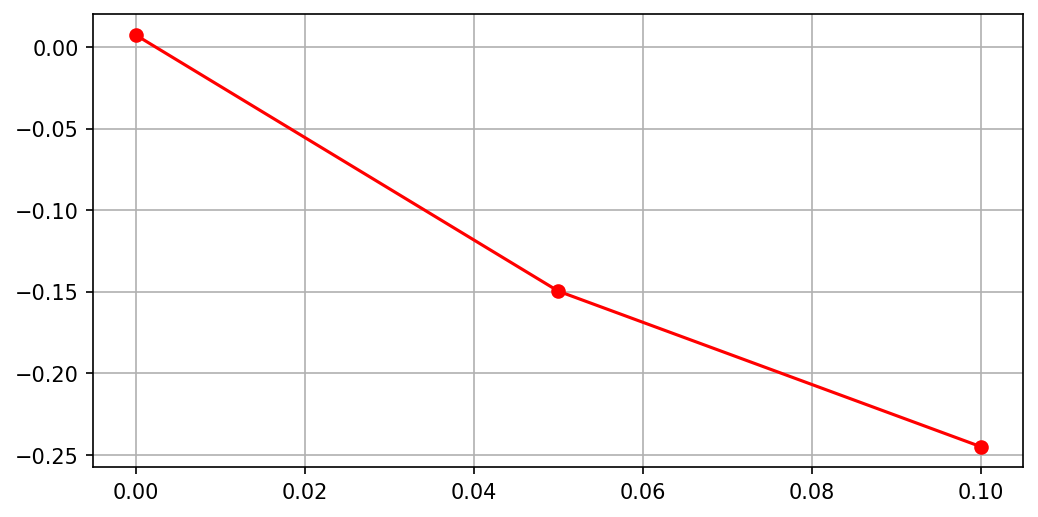

In [28]:
plot_res_list(np.arange(0,N_qite+1)*db/2, [E_thermal])

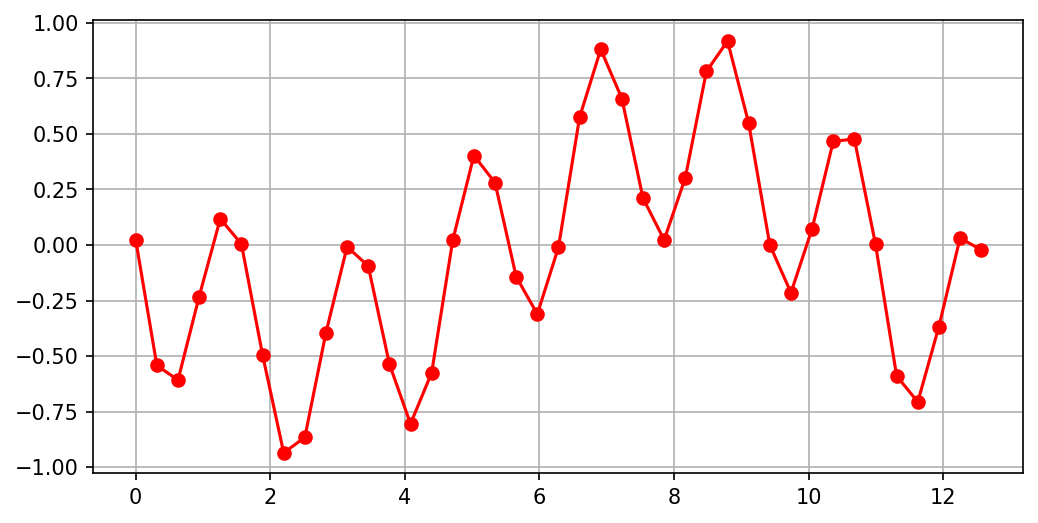

In [29]:
plot_res_list(np.arange(0,N_time+1)*dtime, np.array(corr_expectation_list)[:,1])

In [30]:
def plot_corr_func(xseries, corr_expectation_list):
    real = np.array(corr_expectation_list)[:,0]
    imaginary = np.array(corr_expectation_list)[:,1]
    plt.figure(figsize=[8,4], dpi=150)

    if len(corr_expectation_list) > 1:
        for i in range(len(res_list)):
            re = real[i]
            im = imaginary[i]
            plt.plot(xseries,re,'-r',alpha=0.1)
            plt.plot(xseries,im,'-r',alpha=0.1)
            

        plt.plot(xseries,np.average(real,axis=0),'-r.', label="Real")
        plt.plot(xseries,np.average(imaginary,axis=0),'-b.', label="Imaginary")

    else:
        plt.plot(xseries,real[0],'-r.', label="Real")
        plt.plot(xseries,imaginary[0],'-b.', label="Imaginary")

#     plt.axhline(y=w[0], color='k',linestyle='--',label="Ground state")
#     plt.title("Correlation Function")
#     plt.xlabel("Time")
#     plt.ylabel("Function")
    plt.grid()
    plt.legend(bbox_to_anchor=(1.0,1.0))
    plt.show()

Inverse temperature:  0.2


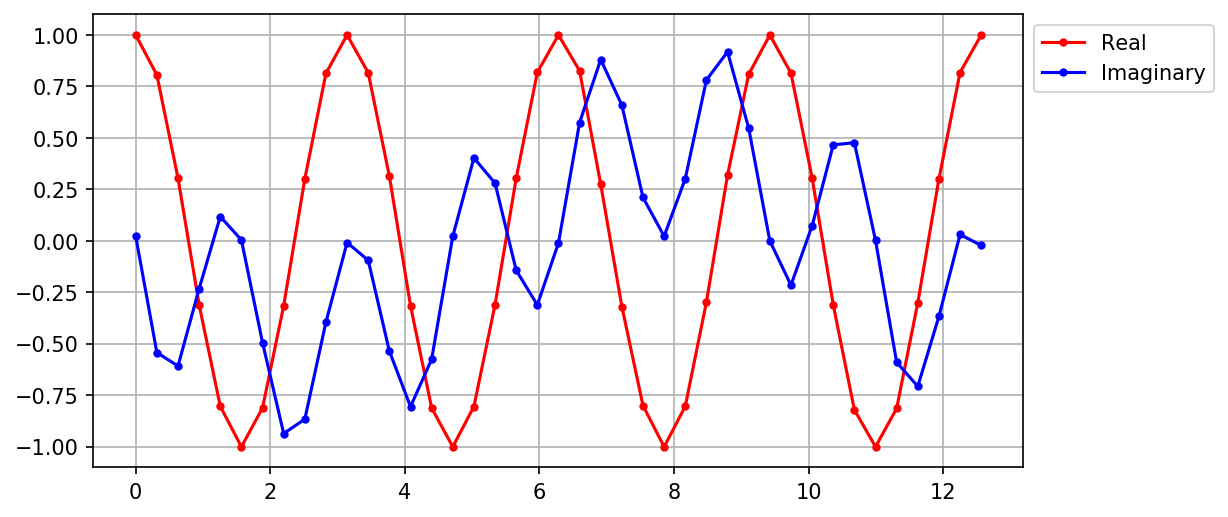

In [31]:
print("Inverse temperature: ", beta)
plot_corr_func(np.arange(0,N_time+1)*dtime, corr_expectation_list)

## Classical computation

In [32]:
# Classical trajectory

# List to store energy values
energy_classical_thermal_list = []

# Initialize into |00...> state
psi = np.zeros([2**nqbits], dtype=complex)
# make it 1001 and normalize
psi[0] = 1.
psi[3] = 1.
psi = psi/np.linalg.norm(psi)

phi = psi

# db = beta/N
expmH = expm(-db/2 * Hamiltonian)

# Store the energy for initial wavefunction
e = np.matmul(Hamiltonian, phi)
e = np.real(np.matmul(np.transpose(np.conj(phi)), e))
energy_classical_thermal_list.append(e)

# Perform imaginary time evolution
for i in range(0,N_qite):

    # Perform imaginary time evolution
    phi = np.matmul(expmH, phi)

    # Require normalization because imaginary time evolution is non-unitary
    phi = phi / np.linalg.norm(phi)

    # Store the energy values at each step
    e = np.matmul(Hamiltonian, phi)
    e = np.real(np.matmul(np.transpose(np.conj(phi)), e))
    energy_classical_thermal_list.append(e)
print('Final energy at beta', beta, 'is ', e)

Final energy at beta 0.2 is  -0.2941405858671832


In [33]:
phi

array([ 0.63207132+0.j, -0.04938612+0.j, -0.04938612+0.j,  0.77175636+0.j])

In [34]:
energy_classical_thermal_list = []

for i in range(0,N_qite+1):
    gibbs = expm(-Hamiltonian * i*db)
    norm_gibbs = np.trace(gibbs)
    gibbs /= norm_gibbs
    print(gibbs)
    thermal_energy = np.trace(np.matmul(gibbs, Hamiltonian)).real
    energy_classical_thermal_list.append(thermal_energy)
    
print("thermal energy at {}: {}".format(beta,energy_classical_thermal_list[-1]))

[[0.25+0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.25+0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.25+0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.25+0.j]]
[[ 0.22512425+0.j  0.        +0.j -0.01758981+0.j  0.        +0.j]
 [ 0.        +0.j  0.22512425+0.j  0.        +0.j -0.01758981+0.j]
 [-0.01758981+0.j  0.        +0.j  0.27487575+0.j  0.        +0.j]
 [ 0.        +0.j -0.01758981+0.j  0.        +0.j  0.27487575+0.j]]
[[ 0.20097657+0.j  0.        +0.j -0.0346648 +0.j  0.        +0.j]
 [ 0.        +0.j  0.20097657+0.j  0.        +0.j -0.0346648 +0.j]
 [-0.0346648 +0.j  0.        +0.j  0.29902343+0.j  0.        +0.j]
 [ 0.        +0.j -0.0346648 +0.j  0.        +0.j  0.29902343+0.j]]
thermal energy at 0.2: -0.2941405858671834


In [35]:
# Unitary time evolution
phi_t = lambda t: np.matmul(expm(-1j * Hamiltonian * t),phi)

# for each trial
corr_func_exp_lst = []
# for real
corr_func_exp_lst.append([])
# for imaginary
corr_func_exp_lst.append([])
for i in range(0,N_time+1):
    corr_func_exp = np.matmul(xi, phi_t(i*dtime))
    corr_func_exp = np.matmul(np.matmul(np.transpose(np.conj(phi)),xi), corr_func_exp)
    corr_func_exp_lst[0].append(np.real(corr_func_exp))
    corr_func_exp_lst[1].append(np.imag(corr_func_exp))
print(corr_func_exp_lst)

[[1.0, 0.9268866826024666, 0.7182378447716118, 0.4045635039173427, 0.03173120332433979, -0.3457410443487794, -0.6726567425962446, -0.9012121090016498, -0.9979862614711787, -0.9488282413540683, -0.7609262605052309, -0.4617565932555196, -0.09506581327961926, 0.28552612065621596, 0.6243665308224026, 0.8719079243077591, 0.99195315617044, 0.966948416131973, 0.8005500631821078, 0.5170899685081446, 0.15801754785294886, -0.22416124706335208, -0.5735616971701134, -0.8390921504523428, -0.981924982290969, -0.9811742283479827, -0.8369496688460242, -0.5703407757758665, -0.220332870377596, 0.16189356919072767, 0.5204468569413297, 0.8028969522117309, 0.967942128072995, 0.9914483838697705, 0.869978478920262, 0.6212945486541128, 0.281760807321753, -0.09897386868240757, -0.4652359289364919, -0.7634681049164358, -0.9500609091410821], [0.0, 0.09014375730467622, 0.16710609633090642, 0.21963307323692804, 0.2400438449538152, 0.2253538130198373, 0.1777110513697318, 0.10408220071193738, 0.015233760101971718, -

Inverse temperature:  0.2


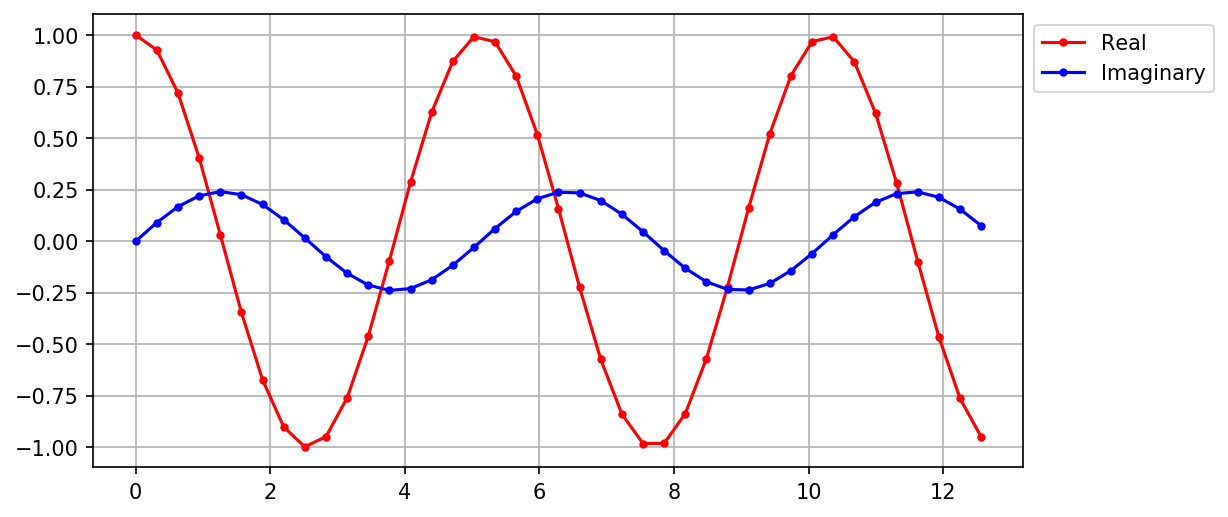

In [36]:
print("Inverse temperature: ", beta)
plot_corr_func(np.arange(0,N_time+1)*dtime, [corr_func_exp_lst])

## Classical QITE Approximation

In [37]:
# energy_qite_list = []

# # QITE trajectory
# phi = psi

# debug_Pmu_expectation_list = []

# # Store the energy for initial wavefunction
# e = np.matmul(Hamiltonian, phi)
# e = np.real(np.matmul(np.transpose(np.conj(phi)), e))
# energy_qite_list.append(e)

# print('We start QITE now')
# for i in range(0,N_qite):

#     # First construct Pmu_expectation matrices
#     Pmu_expectation = np.zeros([16], dtype=complex)
#     for Pmu in range(2**4):
#         ops = Int2Bas(Pmu, 4, 2)
# #         print("ops: ", ops)
#         operator = np.kron(sigma[:, :, ops[0]], sigma[:, :, ops[1]])
#         Pmu_expectation[Pmu] = np.matmul(np.transpose(np.conj(phi)), np.matmul(operator, phi))
        
#     debug_Pmu_expectation_list.append(Pmu_expectation.real.tolist())

#     # Now construct S matrix
#     #propagation_strings = [2, 6, 8, 9, 11, 14]
#     propagation_strings = list(range(16))
#     S = np.zeros([len(propagation_strings), len(propagation_strings)], dtype=complex)
#     for i, ops1 in enumerate(propagation_strings):
#         for j, ops2 in enumerate(propagation_strings):
#             S[i,j] = Pmu_expectation[index[ops1, ops2]]*coeff[ops1, ops2]

#     # Now construct b vector
#     b = np.zeros([len(propagation_strings)], dtype=complex)
    
#     # Compute norm
#     e = np.matmul(Hamiltonian, phi)
#     e = np.real(np.matmul(np.transpose(np.conj(phi)), e))
#     c = np.exp(- (db/2) * e)
        
#     for i, ops1 in enumerate(propagation_strings):
#         b[i] += (Pmu_expectation[i] / c - Pmu_expectation[i]) / (db/2)
#         for k in range(len(hm_list)):
#             hm = hm_list[k]
#             for j in range(len(hm)):
#                 pauli_pair = (hm[j][0][0],hm[j][0][1])
#                 idx = pauli_pair_dict[pauli_pair]
#                 b[i] -= hm[j][1][0] * coeff[ops1, idx] * Pmu_expectation[index[ops1, idx]] / c
#         b[i] = -2 * np.imag(b[i]) * (db/2) / c


#     # Obtain x 
#     dalpha = np.eye(len(propagation_strings)) * 0.1
#     x = np.linalg.lstsq(S + np.transpose(S) + dalpha, -b, rcond=-1)[0]

#     # Classical evolution
#     U = np.eye(4)
#     for i, ops1 in enumerate(propagation_strings):
#         ops = Int2Bas(ops1, 4, 2)
#         operator = np.kron(sigma[:, :, ops[0]], sigma[:, :, ops[1]])
#         U = np.matmul(expm(1j * x[i] * operator), U)
#     phi = np.matmul(U, phi)
    
#     e = np.matmul(Hamiltonian, phi)
#     e = np.real(np.matmul(np.transpose(np.conj(phi)), e))
#     energy_qite_list.append(e)

# # print(debug_Pmu_expectation_list)
# print("thermal energy at {}: {}".format(beta,energy_qite_list[-1]))

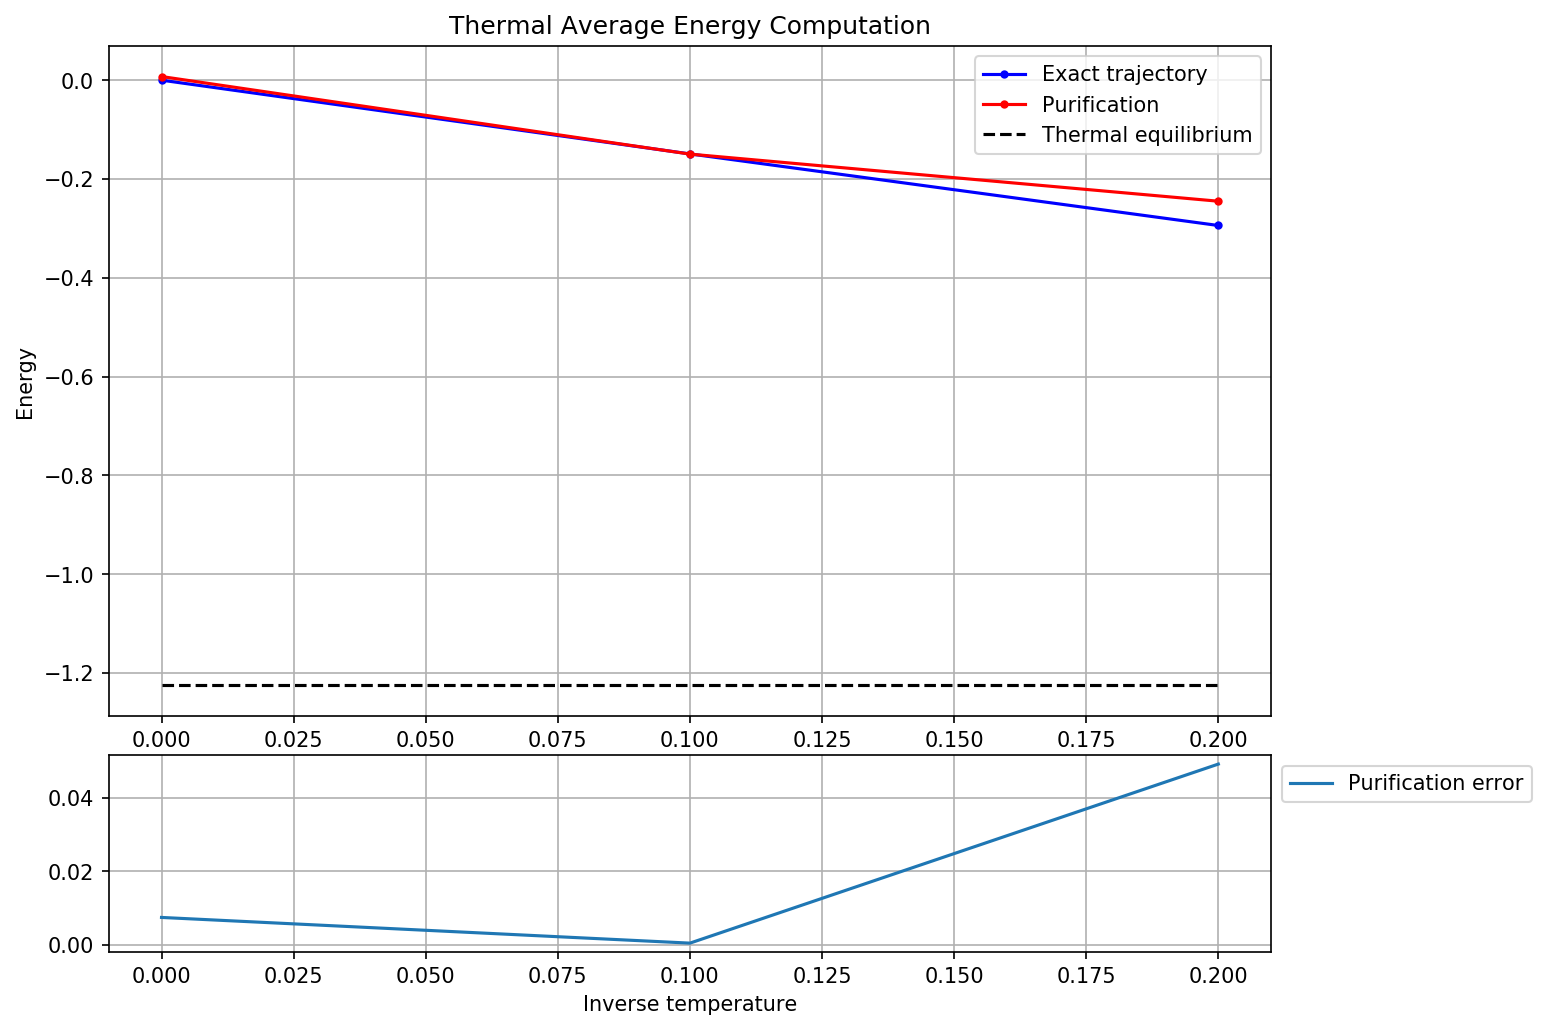

In [38]:
# plt.figure(figsize=(8,4))
  
# imaginary time
beta_list = np.asarray(range(0, N_qite+1)) * db

error = np.sqrt((np.array(E_thermal) - np.array(energy_classical_thermal_list))**2)

plt.figure(figsize=[10,8], dpi=150)
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1, sharex=ax1)    

ax1.plot(beta_list, energy_classical_thermal_list, '-b.', label='Exact trajectory')
# ax1.plot(beta_list, energy_qite_list, '-g.', label='QITE approximation')
ax1.plot(beta_list, E_thermal,'-r.',label='Purification')
ax1.plot([beta_list[0], beta_list[-1]], [w[0], w[0]], '--k', label='Thermal equilibrium')
# ax1.axhline(y=w[0], color='k',linestyle='--',label="Ground state")

ax2.plot(beta_list, error, label="Purification error")

ax1.set_title("Thermal Average Energy Computation")
ax1.set_xlabel("Inverse temperature")
ax1.set_ylabel("Energy")
ax1.legend(bbox_to_anchor=(1.0,1.0))
ax1.grid()

ax2.legend(bbox_to_anchor=(1.0,1.0))
ax2.set_xlabel("Inverse temperature")
ax2.grid()
plt.show()